# Stock Price Simulations

Import required py files and packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Random_Processes import BrownianMotion
from Underlyings import *
import Volatility_Models as vm

Confirming the Martingale Property via Monte-Carlo Simulation

### Visualising Constant-Volatility Dividend-Free Stocks

To visualise and test the implementation of class Stock, I focus on the exponential martingale. I plot a stock price for constant volatility = 1 and drift=0. For the purposes of code testing, I implement this using Stock.Constant_Params, a stock with non-random time varying volatility with a function equal to a constant and the  exponential function.

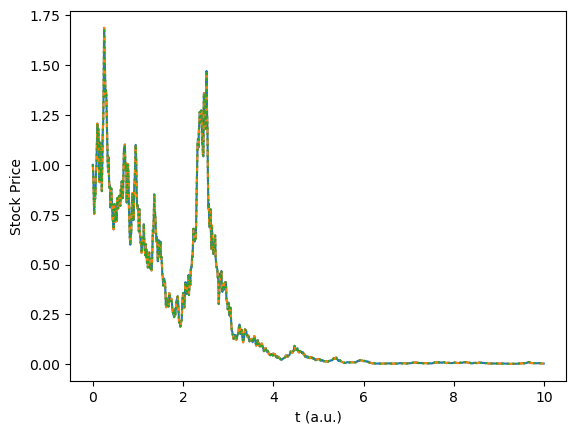

In [46]:
vol=1
#drift=vol+epsilon
drift=0
t=10
W=BrownianMotion(drift=drift,t=0)
W.update(0.01,n=1000,record_steps=1)
S=Stock.Constant_Params(vol=vol, W=W, S0=1,drift=drift,divis=0,Q=None)
S.plot_S_t()

Ss=np.exp(vol*W.get_Ws()-(W.get_ts()*vol**2)/2)
plt.plot(W.get_ts(),Ss,'--')

def always_one(x):
    return x+1-x
vol=vm.NonRandomVol(always_one)
S2=Stock(vol=vol,W=W,S0=1, drift=0)
plt.plot(S2.get_ts(),S2.vals,':')
plt.show()

For $S_0=1$, the expected value of $S(t)$ should be 1, but for large $\sigma^2t$, the plot usually goes to zero. This is due the asymmetry of the log-normal distribution. I perform a Monte-Carlo simulation to estimate the expected value. In particular, I want to check that the drift-free geometric brownian motion $\exp{(\sigma W-\sigma^2t/2)}$ is a martingale.

In [36]:
def run_monte_carlo_simulation(N,vol,ts,print_progress=False):
    t=ts[-1]
    vol.precalculate(0,t)
    RMS_vol=vol.RMS(0,t)

    Sum=0
    SquareSum=0
    n=0
    for i in range(N):
        if i%(N/20)==0 and print_progress:
            print("{}%".format(round(i*100/N),1))
        W=BrownianMotion(drift=0,t=t)
        S=Stock(vol=vol, W=W, S0=1,drift=0,divis=0, Q=None,)
        x=W.get_W()
        Sum+=S.get_S()
        SquareSum+=S.get_S()**2
        n+=1
    
    mean=(Sum/n)
    var=(SquareSum/n-mean**2)

    print("mean={}, var={}, error in mean={}".format(mean,var,np.sqrt(var/N)))

In [47]:
#Test Monte Carlo Simulation for Constant Volatility
sigma=1
vol=vm.ConstantVol(sigma)
t=10
ts=np.linspace(0,10,1000)
run_monte_carlo_simulation(100000,vol,ts,print_progress=True)

0%
5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%
mean=0.9943174570714342, var=1094.6682840280816, error in mean=0.10462639647947747


The Monte Carlo Simulation converges slowly because high stock prices affect the expectation a lot, but the probability of observing them in my sample is very small. The variance in the mean is $\frac{1}{\sqrt{N}}\exp{(\sigma^2t-1)}$, which for large t, vol can be large. I use importance sampling to resolve this.

Let $x=W(t)$, let $p(x)$ be the distribution of a drift-free brownian motion and $q(x)$ be a dummy distribution that I draw values of $W(t)$ from. This will the brownian motion $W(t)+\alpha t$ where $\alpha$ is a drift. To minimize the variance in the montecarlo simulation, I want $q(x)$ to be large when $p(x)S(x)$ is large. We know $p(x)~N(\alpha t, t)$, using calculus, one can show that $max(p(x)f(x))$ is when $x=\sigma t$. This can be done x from $q(x)\sim N(\sigma t,t)$ by introducing a $\alpha=\sigma$ to the brownian motion. It turns out that this is the 'optimal' distribution to draw on, and when $\alpha=\sigma$ the variance vanishes. So as to not have zero variance, one can include a small deviation $\epsilon$ and draw from $q(x)\sim N((\sigma+\epsilon)t, t)$. The expectation is then calculated as $\frac{1}{N}\displaystyle\sum_{i}^{}\frac{p(x_i)S(x_i)}{q(x_i)}$. By comparing $\alpha \approx \sigma$ to $\alpha=0$, you can see that the Monte Carlo simulation converges much faster to a mean=1. The theoretical variance is $exp(\epsilon^2t)-1 \sim \epsilon^2t$ for small t.

In [44]:
def run_mc_importance_sampling(N,vol,ts,drift,print_progress=False):
    
    t=ts[-1]
    vol.precalculate(0,t)
    RMS_vol=vol.RMS(0,t)
    mu=drift*t

    Sum=0
    SquareSum=0
    n=0
    for i in range(N):
        if i%(N/20)==0 and print_progress:
            print("{}%".format(round(i*100/N),1))
        W=BrownianMotion(drift=drift,t=t)
        S=Stock(vol=vol, W=W, S0=1,drift=0,divis=0, Q=None,)
        x=W.get_W()
        p=np.exp(-x**2/(2*t))
        q=np.exp(-(x-mu)**2/(2*t))
        Sum+=S.get_S()*p/q
        SquareSum+=(S.get_S()*p/q)**2
        n+=1
    
    mean=(Sum/n)
    var=(SquareSum/n-mean**2)

    print("mean={}, var={}, error in mean={}".format(mean,var,np.sqrt(var/N)))

In [48]:
#Test Monte Carlo Simulation with Importance Sample for Stock with Constant Volatility
sigma=1
vol=vm.ConstantVol(sigma)

epsilon=0.1
drift=vol.get_vol()+epsilon
run_mc_importance_sampling(N=10000,vol=vol,ts=ts,drift=drift,print_progress=False)

mean=0.995782490536884, var=0.10534970305626501, error in mean=0.003245761899096497


### Non-Random, Time-Varying Volatility

I move to stocks with non-random, time-varying volatility. I visualise them for different volatility functions $\sigma(t)$

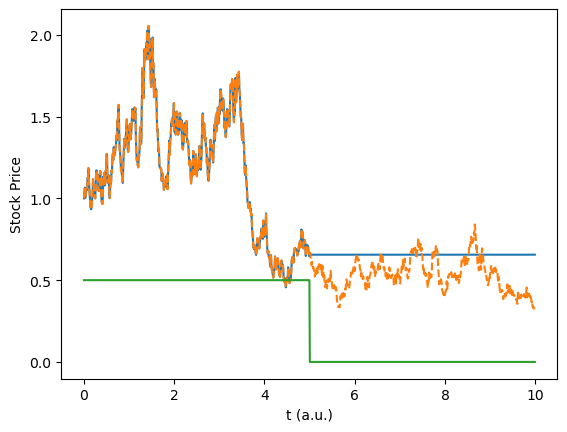

In [49]:
#Compare Non-Random to Constant Volatility
sigma=0.5
ts=np.linspace(0,10,1000)
W=BrownianMotion.from_ts(ts)
vol=vm.NonRandomVol(lambda x: sigma*(x<5))
S=Stock(vol=vol,W=W,S0=1,drift=0)
S.plot_S_t()
Ss=np.exp(sigma*W.get_Ws()-W.get_ts()*sigma**2/2)
plt.plot(W.get_ts(),Ss,'--')
vol.plot_vol_t(W.get_ts())
plt.show()

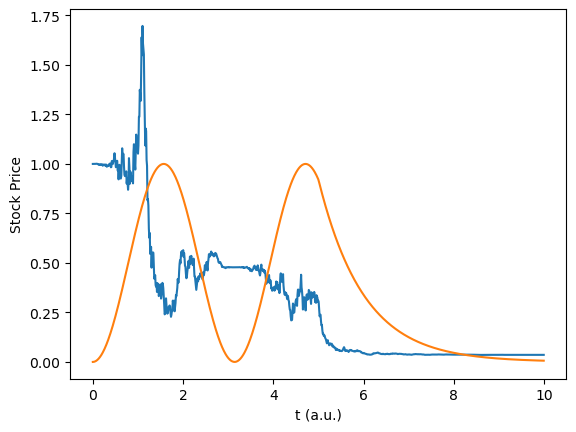

In [50]:
#Visualise non-random volatility
ts=np.linspace(0,10,1000)
W=BrownianMotion.from_ts(ts)
def volfun(x):
   return (x<5)*np.sin(x)**2+(x>=5)*np.sin(5)**2*np.exp(5-x)
vol=vm.NonRandomVol(volfun)
S=Stock(vol=vol,W=W,S0=1,drift=0)
S.plot_S_t()
vol.plot_vol_t(W.get_ts())
plt.show()

In [52]:
#Monte Carlo Simulation for Non-random time varying volatility

def volfun(x):
   return (x<5)*np.sin(x)**2+(x>=5)*np.sin(5)**2*np.exp(5-x)
vol=vm.NonRandomVol(volfun)
RMS_vol=vol.RMS(0,ts[-1])
epsilon=0.2
drift=RMS_vol+epsilon
#drift=0
N=10000
run_mc_importance_sampling(N=N,vol=vol,ts=ts,drift=drift,print_progress=False)

mean=0.9959855208092434, var=0.5206922304772211, error in mean=0.007215900709386328


### Stocks with Dividend payments and drifts

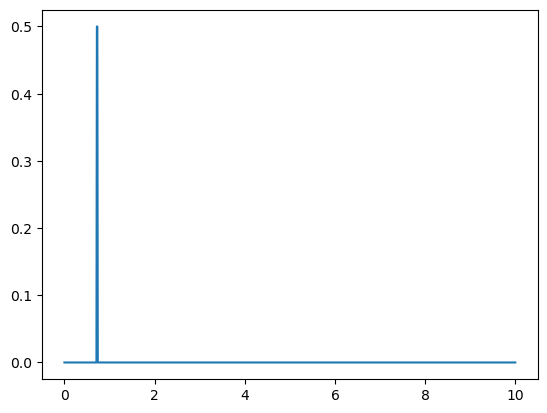

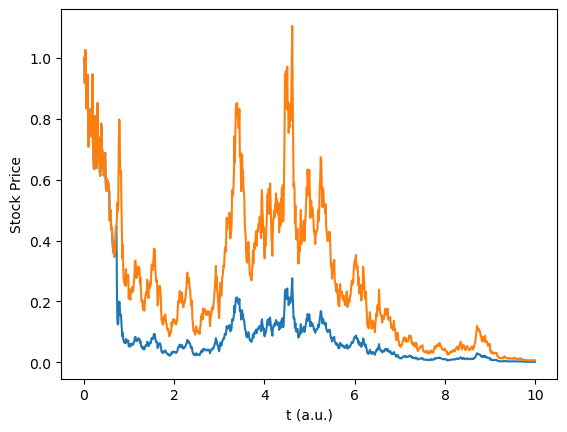

In [55]:
ts=np.linspace(0,10,1000)
divis=0.5*(ts>0.72) * (ts<0.74)
plt.plot(ts,divis)
plt.show()
vol=vm.ConstantVol(1)
W=BrownianMotion.from_ts(ts)
S=Stock(vol=vol,W=W,S0=1,drift=0,divis=divis[:-1])
S2=Stock(vol=vol,W=W,S0=1,drift=0,divis=0)
#S3=Stock(vol=vol,W=W,S0=1,drift=divis[:-1],divis=divis[:-1])
S.plot_S_t()
S2.plot_S_t()
#S3.plot_S_t()
plt.show()

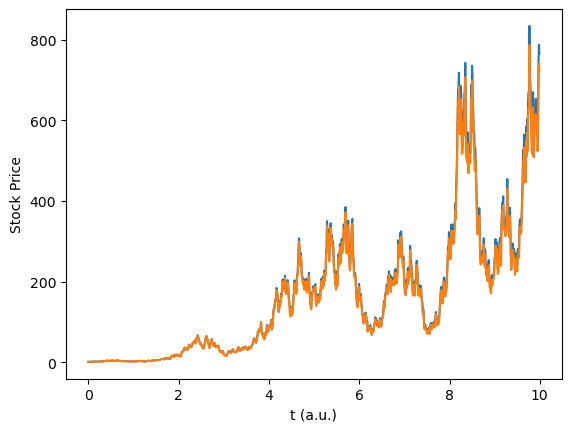

In [21]:
#comparing constant vs array drift

ts=np.linspace(0,10,1000)
vol=vm.ConstantVol(1)
W=BrownianMotion.from_ts(ts)
S1=Stock(vol=vol,W=W,S0=1,drift=1,divis=0)
S2=Stock(vol=vol,W=W,S0=1,drift=np.array([0.01 for _ in range(len(W.get_ts()))]),divis=0)
S1.plot_S_t()
S2.plot_S_t()
plt.show()